In [1]:
# Import needed libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import re

pd.options.display.max_rows = None
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Pointstar/ZLearning/Kubeflow/ps-int-datateamrnd-22072022-c7e65f4577ea.json"

# Data Analysis

In [2]:
# Read data in the excel file

df = pd.read_gbq(
    project_id="ps-int-datateamrnd-22072022", 
    location="asia-southeast2",
    dialect="standard",
    query="""SELECT
                Receipt_No AS ReceiptNo,
                Receipt_Created AS ReceiptDate,
                Product_Code AS ProductCode,
                Product_Group AS ProductGroup,
                Product,
                Qty AS Quantity,
                Unit_Price AS UnitPrice,
                Qty * Unit_Price AS TotalPrice
            FROM
                `ps-int-datateamrnd-22072022.koufu_product_trx_list.product_list`""")
df.head()

c:\Pointstar\venv-dev\lib\site-packages\google\api_core\grpc_helpers.py:37: DeprecationWarning: Support for grpcio-gcp is deprecated. This feature will be
            removed from `google-api-core` after January 1, 2024. If you need to
            continue to use this feature, please pin to a specific version of
            `google-api-core`.
  warnings.warn(


,ReceiptNo,ReceiptDate,ProductCode,ProductGroup,Product,Quantity,UnitPrice,TotalPrice
0,243027,2023-03-29 12:01:06+00:00,P0400003,HOT DRINK,Coffee,2,1.2,2.4
1,241478,2023-03-26 18:01:44+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0
2,241438,2023-03-26 16:01:55+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0
3,241413,2023-03-26 14:56:27+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0
4,241383,2023-03-26 13:48:39+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0


In [3]:
df.shape

(39357, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39357 entries, 0 to 39356
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   ReceiptNo     39357 non-null  Int64              
 1   ReceiptDate   39357 non-null  datetime64[ns, UTC]
 2   ProductCode   39357 non-null  object             
 3   ProductGroup  39357 non-null  object             
 4   Product       39357 non-null  object             
 5   Quantity      39357 non-null  Int64              
 6   UnitPrice     39357 non-null  float64            
 7   TotalPrice    39357 non-null  float64            
dtypes: Int64(2), datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 2.5+ MB


In [5]:
df.describe()

,ReceiptNo,Quantity,UnitPrice,TotalPrice
count,39357.0,39357.0,39357.000000,39357.000000
mean,234095.206469,1.058516,1.833506,2.013210
std,5987.757756,0.407467,1.777693,2.968162
min,223769.0,1.0,0.100000,0.100000
25%,228927.0,1.0,1.200000,1.200000
50%,234095.0,1.0,1.600000,1.600000
75%,239263.0,1.0,2.000000,2.200000
max,244597.0,24.0,32.850000,204.000000


In [6]:
# Check null values
df.isnull().sum()

ReceiptNo       0
ReceiptDate     0
ProductCode     0
ProductGroup    0
Product         0
Quantity        0
UnitPrice       0
TotalPrice      0
dtype: int64

In [7]:
# Check number of unique values
df.nunique()

ReceiptNo       20829
ReceiptDate     20829
ProductCode       207
ProductGroup       10
Product           207
Quantity           13
UnitPrice         126
TotalPrice        194
dtype: int64

In [8]:
# Check each stock code has only one description
df.groupby('ProductCode').apply(lambda x: x['Product'].nunique()).sort_values(ascending=False).head()

ProductCode
P0200018    1
P0500043    1
P0500010    1
P0500018    1
P0500019    1
dtype: int64

In [9]:
# Number of invoices for each country
df.groupby(['ProductGroup']).count()

,ReceiptNo,ReceiptDate,ProductCode,Product,Quantity,UnitPrice,TotalPrice
ProductGroup,,,,,,,
BEER,532,532,532,532,532,532,532
CIGARETTE,474,474,474,474,474,474,474
COLD DRINK,7812,7812,7812,7812,7812,7812,7812
DIM SUM,8,8,8,8,8,8,8
DRINK CONSUMABLES,3130,3130,3130,3130,3130,3130,3130
HOT DRINK,21944,21944,21944,21944,21944,21944,21944
MISC,3861,3861,3861,3861,3861,3861,3861
PREMIUM DRINK,89,89,89,89,89,89,89
PREMIUM FOOD,959,959,959,959,959,959,959


# Data Preprocessing

In [10]:
# Delete rows with null CustomerID
clean_df = df.dropna(subset = ['ReceiptNo'])

# Check null values
clean_df.isnull().sum()

ReceiptNo       0
ReceiptDate     0
ProductCode     0
ProductGroup    0
Product         0
Quantity        0
UnitPrice       0
TotalPrice      0
dtype: int64

In [11]:
# Removing the price and quantity that are less than or equal to 0
clean_df = clean_df[(clean_df.Quantity >= 0) & (clean_df.UnitPrice >= 0)]

# Check min values
clean_df.describe()

,ReceiptNo,Quantity,UnitPrice,TotalPrice
count,39357.0,39357.0,39357.000000,39357.000000
mean,234095.206469,1.058516,1.833506,2.013210
std,5987.757756,0.407467,1.777693,2.968162
min,223769.0,1.0,0.100000,0.100000
25%,228927.0,1.0,1.200000,1.200000
50%,234095.0,1.0,1.600000,1.600000
75%,239263.0,1.0,2.000000,2.200000
max,244597.0,24.0,32.850000,204.000000


In [12]:
# Check the number of invoices that starts with letter 'c', cancellation.
clean_df['ReceiptNo'] = clean_df['ReceiptNo'].astype('str')
clean_df[clean_df['ReceiptNo'].str.contains("c")].shape[0]

0

In [13]:
# Check the product code
def has_right_pcode(input):
    
    """
    Function: check if the product code is wirtten in a right way,
            The function check if the code contains 7-digit number or 7-digit number with a letter.
    Args:
      input(String): Product code
    Return:
      Boolean: True or False
    """
    
    x = re.search('^\\d{7}$', input)
    y = re.search('^[a-zA-Z]{1}\\d{7}$', input)
    if (x or y):
        return True
    else:
        return False


clean_df['ProductCode'] = clean_df['ProductCode'].astype('str')
clean_df = clean_df[clean_df['ProductCode'].apply(has_right_pcode) == True]
clean_df.head()

,ReceiptNo,ReceiptDate,ProductCode,ProductGroup,Product,Quantity,UnitPrice,TotalPrice
0,243027,2023-03-29 12:01:06+00:00,P0400003,HOT DRINK,Coffee,2,1.2,2.4
1,241478,2023-03-26 18:01:44+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0
2,241438,2023-03-26 16:01:55+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0
3,241413,2023-03-26 14:56:27+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0
4,241383,2023-03-26 13:48:39+00:00,P0400011,HOT DRINK,Coffee C Ice,1,2.0,2.0


In [14]:
# One discription for each product code

# Put all Descriptions of each ProductCode in a list 
df_itms = pd.DataFrame(clean_df.groupby('ProductCode').apply(lambda x: x['Product'].unique())).reset_index()
df_itms.rename(columns = { 0: 'ProductClean'}, inplace = True)

# ProductCode that have more than one Description
df_itms[df_itms['ProductClean'].str.len() != 1]

,ProductCode,ProductClean


In [15]:
# Take one Description for each ProductCode
df_itms.loc[:, 'ProductClean'] = df_itms.ProductClean.map(lambda x: x[0])

# ProductCode that have more than one Description
df_itms[df_itms['ProductClean'].str.len() != 1]

,ProductCode,ProductClean
0,P0200018,LD Red Box
1,P0200020,LD Lights Box
2,P0200021,LD Menthol Box
3,P0200023,Marlboro White Menthol
4,P0200025,L&M Red Line
5,P0200026,L&M Green Line
6,P0200029,Marlboro Gold
7,P0200030,Marlboro Mega Ice Blast
8,P0200032,Marlboro Red
9,P0200033,Marlboro Menthol


In [16]:
# Merge clean_df with df_itms
clean_df = pd.merge(clean_df, df_itms, on = 'ProductCode')
clean_df = clean_df.drop('Product', axis = 1)
clean_df.head()

,ReceiptNo,ReceiptDate,ProductCode,ProductGroup,Quantity,UnitPrice,TotalPrice,ProductClean
0,243027,2023-03-29 12:01:06+00:00,P0400003,HOT DRINK,2,1.2,2.4,Coffee
1,241285,2023-03-26 11:48:28+00:00,P0400003,HOT DRINK,1,4.0,4.0,Coffee
2,236838,2023-03-19 16:44:27+00:00,P0400003,HOT DRINK,1,4.0,4.0,Coffee
3,233899,2023-03-15 17:18:35+00:00,P0400003,HOT DRINK,5,1.2,6.0,Coffee
4,230221,2023-03-10 16:39:40+00:00,P0400003,HOT DRINK,5,1.2,6.0,Coffee


In [17]:
clean_df.rename(columns = { 'ProductClean': 'Product'}, inplace = True)
clean_df.head()

,ReceiptNo,ReceiptDate,ProductCode,ProductGroup,Quantity,UnitPrice,TotalPrice,Product
0,243027,2023-03-29 12:01:06+00:00,P0400003,HOT DRINK,2,1.2,2.4,Coffee
1,241285,2023-03-26 11:48:28+00:00,P0400003,HOT DRINK,1,4.0,4.0,Coffee
2,236838,2023-03-19 16:44:27+00:00,P0400003,HOT DRINK,1,4.0,4.0,Coffee
3,233899,2023-03-15 17:18:35+00:00,P0400003,HOT DRINK,5,1.2,6.0,Coffee
4,230221,2023-03-10 16:39:40+00:00,P0400003,HOT DRINK,5,1.2,6.0,Coffee


### 1. All Data

In [18]:
df_itms_togthr = clean_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr.head()

ReceiptNo  Product           
235560     Heineken Quart        24
229742     Soya Bean Water       12
244579     Carlsberg Quart       12
226017     Takeaway Cup $0.20    11
225533     Takeaway Cup $0.20    11
Name: Quantity, dtype: Int64

In [19]:
df_itms_togthr = df_itms_togthr.unstack().fillna(0)
df_itms_togthr.head()

Product,$1 ATH,3 Layer Ice Coffee (L),3 Layer Ice Tea (L),3C Ice Coffee,3C Ice Tea,Add Lemon,Almond Milk (B),Aloe Vera Honey(B),Asahi Super Dry Quart,BBQ Chicken Polo Bun,...,Yuan Yang,Yuan Yang + C,Yuan Yang C,Yuan Yang C Ice,Yuan Yang C Ice (L),Yuan Yang Ice,Yuan Yang Ice (L),Yuan Yang O,Yuan Yang O Ice,Yuzu Lime Sparkling
ReceiptNo,,,,,,,,,,,,,,,,,,,,,
223769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Encode the frequency of description to 0 or 1
encode = lambda x : True if (x >= 1) else False
df_itms_togthr = df_itms_togthr.applymap(encode)
df_itms_togthr.head()

Product,$1 ATH,3 Layer Ice Coffee (L),3 Layer Ice Tea (L),3C Ice Coffee,3C Ice Tea,Add Lemon,Almond Milk (B),Aloe Vera Honey(B),Asahi Super Dry Quart,BBQ Chicken Polo Bun,...,Yuan Yang,Yuan Yang + C,Yuan Yang C,Yuan Yang C Ice,Yuan Yang C Ice (L),Yuan Yang Ice,Yuan Yang Ice (L),Yuan Yang O,Yuan Yang O Ice,Yuzu Lime Sparkling
ReceiptNo,,,,,,,,,,,,,,,,,,,,,
223769,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223771,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223772,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223773,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
df_itms_togthr.shape

(20829, 207)

# Modeling

In [22]:
# Build the Apriori model
rep_items = apriori(df_itms_togthr, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items['length'] = rep_items['itemsets'].apply(lambda x: len(x))
rep_items.sort_values(by=['length'], ascending=False).head(10)

Processing 45 combinations | Sampling itemset size 3 2


,support,itemsets,length
42,0.010802,"(Teh C, Takeaway Cup $0.20)",2
41,0.031927,"(Teh, Takeaway Cup $0.20)",2
40,0.024869,"(Coffee O, Takeaway Cup $0.20)",2
39,0.013875,"(Coffee C, Takeaway Cup $0.20)",2
38,0.013827,"(Coffee, Teh)",2
37,0.058428,"(Coffee, Takeaway Cup $0.20)",2
36,0.017476,"(Coffee, Kaya Toast n Egg)",2
35,0.010850,"(Coffee, Coffee O)",2
29,0.053915,(Teh C),1
24,0.016323,(Milo Ice (L)),1


In [23]:
# Generate the association rules dataframe
rules = association_rules(rep_items, metric = "confidence", min_threshold = 0.0)
rules.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5,(Takeaway Cup $0.20),(Coffee),0.146478,0.173364,0.058428,0.398886,2.300855,0.033034,1.375172,0.662407
4,(Coffee),(Takeaway Cup $0.20),0.173364,0.146478,0.058428,0.337026,2.300855,0.033034,1.287413,0.683952
12,(Teh),(Takeaway Cup $0.20),0.097892,0.146478,0.031927,0.326140,2.226541,0.017588,1.266616,0.610651
3,(Kaya Toast n Egg),(Coffee),0.053723,0.173364,0.017476,0.325290,1.876343,0.008162,1.225173,0.493564
8,(Coffee C),(Takeaway Cup $0.20),0.063517,0.146478,0.013875,0.218443,1.491297,0.004571,1.092078,0.351787
13,(Takeaway Cup $0.20),(Teh),0.146478,0.097892,0.031927,0.217961,2.226541,0.017588,1.153533,0.645412
10,(Coffee O),(Takeaway Cup $0.20),0.117384,0.146478,0.024869,0.211861,1.446362,0.007675,1.082958,0.349654
14,(Teh C),(Takeaway Cup $0.20),0.053915,0.146478,0.010802,0.200356,1.367820,0.002905,1.067377,0.284234
11,(Takeaway Cup $0.20),(Coffee O),0.146478,0.117384,0.024869,0.169780,1.446362,0.007675,1.063111,0.361573
7,(Teh),(Coffee),0.097892,0.173364,0.013827,0.141246,0.814735,-0.003144,0.962599,-0.201322


In [24]:
# The number of rules
rules.shape[0]

16

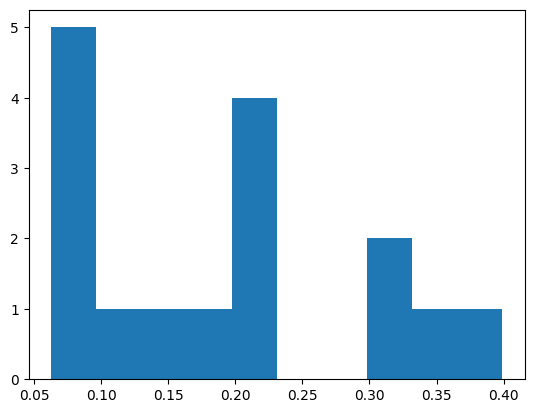

In [25]:
# Show confidence distribution
plt.hist(rules['confidence'])
plt.show()

In [26]:
# Show the rules that have confidance > 0.35
high_confidance = rules[rules['confidence'] > 0.3]
high_confidance [['antecedents', 'consequents']]

,antecedents,consequents
3,(Kaya Toast n Egg),(Coffee)
4,(Coffee),(Takeaway Cup $0.20)
5,(Takeaway Cup $0.20),(Coffee)
12,(Teh),(Takeaway Cup $0.20)


### 2. HOT DRINK

In [27]:
hd_df = clean_df[clean_df['ProductGroup'] == 'HOT DRINK']
dc_df = clean_df[clean_df['ProductGroup'] == 'DRINK CONSUMABLES']
sh_df = clean_df[clean_df['ProductGroup'] == 'SHELF']
pf_df = clean_df[clean_df['ProductGroup'] == 'PREMIUM FOOD']
cd_df = clean_df[clean_df['ProductGroup'] == 'COLD DRINK']
br_df = clean_df[clean_df['ProductGroup'] == 'BEER']
cg_df = clean_df[clean_df['ProductGroup'] == 'CIGARETTE']
ms_df = clean_df[clean_df['ProductGroup'] == 'MISC']
pd_df = clean_df[clean_df['ProductGroup'] == 'PREMIUM DRINK']
ds_df = clean_df[clean_df['ProductGroup'] == 'DIM SUM']


df_itms_togthr_hd = hd_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_hd = df_itms_togthr_hd.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_hd = df_itms_togthr_hd.applymap(encode)
df_itms_togthr_hd.head()

Product,3 Layer Ice Coffee (L),3 Layer Ice Tea (L),3C Ice Coffee,3C Ice Tea,Beverage EXCESS,Cappucino,Cappucino Ice,Cappucino Ice(L),Chinese Tea,Choc Latte Ice,...,Traditional NanyangCoffee O LS,Yuan Yang,Yuan Yang + C,Yuan Yang C,Yuan Yang C Ice,Yuan Yang C Ice (L),Yuan Yang Ice,Yuan Yang Ice (L),Yuan Yang O,Yuan Yang O Ice
ReceiptNo,,,,,,,,,,,,,,,,,,,,,
223769,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223771,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223772,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
223773,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [28]:
rep_items_hd = apriori(df_itms_togthr_hd, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_hd['length'] = rep_items_hd['itemsets'].apply(lambda x: len(x))
rep_items_hd.sort_values(by=['length'], ascending=False).head(10)

Processing 3 combinations | Sampling itemset size 3 2


,support,itemsets,length
22,0.017975,"(Coffee, Teh)",2
21,0.014106,"(Coffee, Coffee O)",2
12,0.021221,(Milo Ice (L)),1
20,0.018537,(Teh O Ice (L)),1
19,0.026838,(Teh O Ice),1
18,0.078455,(Teh O),1
17,0.034827,(Teh Ice (L)),1
16,0.050618,(Teh Ice),1
15,0.070091,(Teh C),1
14,0.127263,(Teh),1


In [29]:
rules_hd = association_rules(rep_items_hd, metric = "confidence", min_threshold = 0.0)
rules_hd.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(Teh),(Coffee),0.127263,0.225378,0.017975,0.141246,0.626707,-0.010707,0.902030,-0.405646
1,(Coffee O),(Coffee),0.152603,0.225378,0.014106,0.092434,0.410127,-0.020288,0.853516,-0.629255
2,(Coffee),(Teh),0.225378,0.127263,0.017975,0.079756,0.626707,-0.010707,0.948376,-0.434691
0,(Coffee),(Coffee O),0.225378,0.152603,0.014106,0.062587,0.410127,-0.020288,0.903974,-0.649950


### 3. DRINK CONSUMABLES

In [30]:
df_itms_togthr_dc = dc_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_dc = df_itms_togthr_dc.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_dc = df_itms_togthr_dc.applymap(encode)

rep_items_dc = apriori(df_itms_togthr_dc, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_dc['length'] = rep_items_dc['itemsets'].apply(lambda x: len(x))
rep_items_dc.sort_values(by=['length'], ascending=False).head(10)

Processing 110 combinations | Sampling itemset size 2


,support,itemsets,length
11,0.014840,"(Bun n Egg, Kaya Toast n Egg)",2
12,0.015221,"(French Loaf n Egg, Kaya Toast n Egg)",2
0,0.022451,(Bun),1
1,0.176560,(Bun n Egg),1
2,0.020548,(Bun x2),1
3,0.014840,(Egg x1),1
4,0.083714,(Egg x2),1
5,0.018645,(French Loaf),1
6,0.130137,(French Loaf n Egg),1
7,0.017504,(French Loaf x2),1


In [31]:
rules_dc = association_rules(rep_items_dc, metric = "confidence", min_threshold = 0.0)
rules_dc.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(French Loaf n Egg),(Kaya Toast n Egg),0.130137,0.425799,0.015221,0.116959,0.274681,-0.040192,0.650254,-0.752207
0,(Bun n Egg),(Kaya Toast n Egg),0.176560,0.425799,0.014840,0.084052,0.197398,-0.060339,0.626892,-0.831585
3,(Kaya Toast n Egg),(French Loaf n Egg),0.425799,0.130137,0.015221,0.035746,0.274681,-0.040192,0.902110,-0.821387
1,(Kaya Toast n Egg),(Bun n Egg),0.425799,0.176560,0.014840,0.034853,0.197398,-0.060339,0.853175,-0.876253


### 4. SHELF	

In [32]:
df_itms_togthr_sh = sh_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_sh = df_itms_togthr_sh.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_sh = df_itms_togthr_sh.applymap(encode)

rep_items_sh = apriori(df_itms_togthr_sh, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_sh['length'] = rep_items_sh['itemsets'].apply(lambda x: len(x))
rep_items_sh.sort_values(by=['length'], ascending=False).head(10)

Processing 3 combinations | Sampling itemset size 32


,support,itemsets,length
12,0.010152,"(Raisin Butter Cake, Walnut Butter Cake, Banan...",3
9,0.010152,"(Raisin Butter Cake, Banana Butter Cake)",2
10,0.025381,"(Walnut Butter Cake, Banana Butter Cake)",2
11,0.022843,"(Walnut Butter Cake, Raisin Butter Cake)",2
0,0.177665,(Banana Butter Cake),1
1,0.015228,(Fish Crackers ),1
2,0.332487,(Good Old Taste Biscuits),1
3,0.017766,(Mable Butter Cake),1
4,0.012690,(Prawn Crackers ),1
5,0.010152,(Pumpkin Crackers),1


In [33]:
rules_sh = association_rules(rep_items_sh, metric = "confidence", min_threshold = 0.0)
rules_sh.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
7,"(Banana Butter Cake, Raisin Butter Cake)",(Walnut Butter Cake),0.010152,0.284264,0.010152,1.000000,3.517857,0.007266,inf,0.723077
6,"(Walnut Butter Cake, Raisin Butter Cake)",(Banana Butter Cake),0.022843,0.177665,0.010152,0.444444,2.501587,0.006094,1.480203,0.614286
8,"(Walnut Butter Cake, Banana Butter Cake)",(Raisin Butter Cake),0.025381,0.203046,0.010152,0.400000,1.970000,0.004999,1.328257,0.505208
3,(Banana Butter Cake),(Walnut Butter Cake),0.177665,0.284264,0.025381,0.142857,0.502551,-0.025123,0.835025,-0.546218
5,(Raisin Butter Cake),(Walnut Butter Cake),0.203046,0.284264,0.022843,0.112500,0.395759,-0.034876,0.806463,-0.657039
2,(Walnut Butter Cake),(Banana Butter Cake),0.284264,0.177665,0.025381,0.089286,0.502551,-0.025123,0.902956,-0.580357
4,(Walnut Butter Cake),(Raisin Butter Cake),0.284264,0.203046,0.022843,0.080357,0.395759,-0.034876,0.866591,-0.680835
1,(Banana Butter Cake),(Raisin Butter Cake),0.177665,0.203046,0.010152,0.057143,0.281429,-0.025922,0.845255,-0.756391
11,(Banana Butter Cake),"(Walnut Butter Cake, Raisin Butter Cake)",0.177665,0.022843,0.010152,0.057143,2.501587,0.006094,1.036379,0.729938
0,(Raisin Butter Cake),(Banana Butter Cake),0.203046,0.177665,0.010152,0.050000,0.281429,-0.025922,0.865616,-0.762121


### 5. PREMIUM FOOD

In [34]:
df_itms_togthr_pf = pf_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_pf = df_itms_togthr_pf.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_pf = df_itms_togthr_pf.applymap(encode)

rep_items_pf = apriori(df_itms_togthr_pf, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_pf['length'] = rep_items_pf['itemsets'].apply(lambda x: len(x))
rep_items_pf.sort_values(by=['length'], ascending=False).head(10)

Processing 210 combinations | Sampling itemset size 2


,support,itemsets,length
0,0.074434,(BBQ Chicken Polo Bun),1
1,0.111650,(Chicken Floss Bun (Box)),1
2,0.071197,(Coffee Boy (Box)),1
3,0.040453,(Curry Bun (Box)),1
4,0.085761,(Double Cheese Bun (1 Box)),1
5,0.111650,(Ham n Cheddar Cheese Bun (Box)),1
6,0.077670,(Hokkaido Milk Polo Bun (Box)),1
7,0.046926,(Hot Dog n Cheese Bun (Box)),1
8,0.032362,(Japanese Red Bean Bun (Box)),1
9,0.084142,(Japanese Soft Cheese Bun (Box)),1


In [35]:
rules_pf = association_rules(rep_items_pf, metric = "confidence", min_threshold = 0.0)
rules_pf.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### 6. COLD DRINK

In [36]:
df_itms_togthr_cd = cd_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_cd = df_itms_togthr_cd.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_cd = df_itms_togthr_cd.applymap(encode)

rep_items_cd = apriori(df_itms_togthr_cd, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_cd['length'] = rep_items_cd['itemsets'].apply(lambda x: len(x))
rep_items_cd.sort_values(by=['length'], ascending=False).head(10)

Processing 1260 combinations | Sampling itemset size 2


,support,itemsets,length
0,0.012736,(Balonglong (B)),1
1,0.011247,(Bandung (B)),1
20,0.010916,(Iced Limau Tea O),1
21,0.014720,(Iced Limau Tea O (L)),1
22,0.014059,(JestPlay Bandung),1
23,0.016209,(JestPlay Bandung (L)),1
24,0.051439,(JestPlay Lime),1
25,0.034072,(JestPlay Lime (L)),1
26,0.071287,(Koufu Oxygenated Water),1
27,0.021667,(Orange with Honey (B)),1


In [37]:
rules_cd = association_rules(rep_items_cd, metric = "confidence", min_threshold = 0.0)
rules_cd.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### 7. BEER

In [38]:
df_itms_togthr_br = br_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_br = df_itms_togthr_br.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_br = df_itms_togthr_br.applymap(encode)

rep_items_br = apriori(df_itms_togthr_br, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_br['length'] = rep_items_br['itemsets'].apply(lambda x: len(x))
rep_items_br.sort_values(by=['length'], ascending=False).head(10)

Processing 9 combinations | Sampling itemset size 32


,support,itemsets,length
6,0.020513,"(Guinness Quart, Carlsberg Quart)",2
7,0.017949,"(Heineken Quart, Carlsberg Quart)",2
8,0.010256,"(Tiger Beer Quart, Guinness Quart)",2
0,0.371795,(Carlsberg Quart),1
1,0.010256,(Cass Fresh Pint 330ml),1
2,0.084615,(Guinness Quart),1
3,0.274359,(Heineken Quart),1
4,0.015385,(Jinro Chamisul Pint 360ml),1
5,0.287179,(Tiger Beer Quart),1


In [39]:
rules_br = association_rules(rep_items_br, metric = "confidence", min_threshold = 0.0)
rules_br.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Guinness Quart),(Carlsberg Quart),0.084615,0.371795,0.020513,0.242424,0.652038,-0.010947,0.829231,-0.368281
5,(Guinness Quart),(Tiger Beer Quart),0.084615,0.287179,0.010256,0.121212,0.422078,-0.014043,0.811141,-0.599327
2,(Heineken Quart),(Carlsberg Quart),0.274359,0.371795,0.017949,0.065421,0.175959,-0.084057,0.672179,-0.865840
1,(Carlsberg Quart),(Guinness Quart),0.371795,0.084615,0.020513,0.055172,0.652038,-0.010947,0.968838,-0.459310
3,(Carlsberg Quart),(Heineken Quart),0.371795,0.274359,0.017949,0.048276,0.175959,-0.084057,0.762449,-0.881724
4,(Tiger Beer Quart),(Guinness Quart),0.287179,0.084615,0.010256,0.035714,0.422078,-0.014043,0.949288,-0.657635


### 8. CIGARETTE

In [40]:
df_itms_togthr_cg = cg_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_cg = df_itms_togthr_cg.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_cg = df_itms_togthr_cg.applymap(encode)

rep_items_cg = apriori(df_itms_togthr_cg, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_cg['length'] = rep_items_cg['itemsets'].apply(lambda x: len(x))
rep_items_cg.sort_values(by=['length'], ascending=False).head(10)

Processing 240 combinations | Sampling itemset size 2


,support,itemsets,length
0,0.244111,(Camel Filter Box),1
1,0.047109,(L&M Blue Line),1
2,0.025696,(L&M Chill Menthol),1
3,0.029979,(L&M Fast Forward),1
4,0.036403,(L&M Green Line),1
5,0.104925,(L&M Red Line),1
6,0.023555,(LD Lights Box),1
7,0.068522,(LD Menthol Box),1
8,0.092077,(LD Red Box),1
9,0.059957,(Marlboro Gold),1


In [41]:
rules_cg = association_rules(rep_items_cg, metric = "confidence", min_threshold = 0.0)
rules_cg.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### 9. MISC

In [42]:
df_itms_togthr_ms = ms_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_ms = df_itms_togthr_ms.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_ms = df_itms_togthr_ms.applymap(encode)

rep_items_ms = apriori(df_itms_togthr_ms, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_ms['length'] = rep_items_ms['itemsets'].apply(lambda x: len(x))
rep_items_ms.sort_values(by=['length'], ascending=False).head(10)

Processing 12 combinations | Sampling itemset size 2


,support,itemsets,length
0,0.031194,(Add Lemon),1
1,0.022196,(Hot Water),1
2,0.915117,(Takeaway Cup $0.20),1
3,0.023695,(Tissue),1


In [43]:
rules_ms = association_rules(rep_items_ms, metric = "confidence", min_threshold = 0.0)
rules_ms.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### 10. PREMIUM DRINK

In [44]:
df_itms_togthr_pd = pd_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_pd = df_itms_togthr_pd.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_pd = df_itms_togthr_pd.applymap(encode)

rep_items_pd = apriori(df_itms_togthr_pd, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_pd['length'] = rep_items_pd['itemsets'].apply(lambda x: len(x))
rep_items_pd.sort_values(by=['length'], ascending=False).head(10)

Processing 2 combinations | Sampling itemset size 2


,support,itemsets,length
0,0.102273,(Ice J wNata de Coco(B)(Cancel)),1
1,0.897727,(Ice Jelly wNata de Coco (B)),1


In [45]:
rules_pd = association_rules(rep_items_pd, metric = "confidence", min_threshold = 0.0)
rules_pd.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### 11. DIM SUM

In [46]:
df_itms_togthr_ds = ds_df.groupby(['ReceiptNo','Product'])['Quantity'].sum().sort_values(ascending=False)
df_itms_togthr_ds = df_itms_togthr_ds.unstack().fillna(0)

encode = lambda x : True if (x >= 1) else False
df_itms_togthr_ds = df_itms_togthr_ds.applymap(encode)

rep_items_ds = apriori(df_itms_togthr_ds, min_support = 0.01, use_colnames = True, verbose = 1)
rep_items_ds['length'] = rep_items_ds['itemsets'].apply(lambda x: len(x))
rep_items_ds.sort_values(by=['length'], ascending=False).head(10)

,support,itemsets,length
0,1.0,(Kaya You Tiao n Egg),1


In [47]:
rules_ds = association_rules(rep_items_ds, metric = "confidence", min_threshold = 0.0)
rules_ds.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


In [53]:
print(float(rules_sh.loc[:, 'conviction'].mean()))
type(float(rules_sh.loc[:, 'conviction'].mean()))
print("test")
print(str(rules_sh.loc[:, 'conviction'].mean()))

inf
test
inf
